# guiding question:

What if we just used the forward model to get exchange between substrate pools and calculate the probabilities based on the proportions of substrate? Like what's the probability of getting a 15NH2OH and a 15NO? Then we can add these to get the total production of 46N2O that we would expect from that combination of processes — and likewise for each of the other isotopomers as well.

# next:

- separate out rate constants for different steps in AOA ammonia oxidation pathway
- which version of the model best explains the data?

# initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# use for initialization
from collections import namedtuple

# use for plotting interpolations of measured incubation data
import scipy.interpolate as interp

# use for nelder-mead optimization of a convex function
from scipy.optimize import minimize
from numpy.random import rand

import scripts as sc # Python scripts containing helper functions

Set up the model:

In [2]:
### READ IN TRAINING DATA ###
path_to_data = sc.datapath()
filename = '00_incubationdata.csv'

PS2SCM15NO2 = sc.grid_data(filename=f'{path_to_data}{filename}',
                          station="PS2", feature="SCM", tracer="NO2-", 
                          T=1000)

In [3]:
### SUBSTRATE CONCENTRATIONS AND RATES OF EXCHANGE ###
bgc = sc.BioGeoChemistry("PS2SCM", tracer="NO2-")

In [4]:
### ISOTOPE EFFECTS ###
isos = sc.IsotopeEffects()

In [5]:
### MODEL PARAMS ###
(dt, T, times) = sc.modelparams()

### STATE VARIABLES ###
tr = sc.Tracers(bgc, PS2SCM15NO2) 

In [6]:
### INITIAL GUESS FOR OPTIMIZATION ###
x = sc.kestimates(bgc,
                  inputdata=pd.read_csv(f'{sc.datapath()}00_incubationdata.csv'),
                  station="PS2", feature="SCM", hybridtracer="NO2-") 

In [9]:
x

[0.0, 2.8050367317752543e-09, 2.633772229350046e-09, 3.944363997256793e-08]

# model setup

In [10]:
def modelv1(x, tracers):

    ### UNPACK X ###
    [knitrification, kdenitno2, kdenitno3, khybrid] = x

    ### TIME STEPPING ###
    for iT in range(T-1):

        Jhybrid = khybrid*(tracers.nh4_14[iT]+tracers.nh4_15[iT])*(tracers.no2_14[iT]+tracers.no2_15[iT])

        Jnitrification = knitrification*((tracers.nh4_14[iT]+tracers.nh4_15[iT])**2)
        Jdenitno2 = kdenitno2*((tracers.no2_14[iT]+tracers.no2_15[iT])**2)
        Jdenitno3 = kdenitno3*((tracers.no3_14[iT]+tracers.no3_15[iT])**2)

        # update substrate values
        tracers.nh4_14[iT+1,:] = tracers.nh4_14[iT,:] + dt*(
            -bgc.kNH4TONO2*tracers.nh4_14[iT]

            -Jnitrification*(1-tracers.afnh4[iT,:])
            -Jhybrid*(1-tracers.afnh4[iT,:]))

        tracers.nh4_15[iT+1,:] = tracers.nh4_15[iT,:] + dt*(
            -bgc.kNH4TONO2/isos.alpha15NH4TONO2AOA*tracers.nh4_15[iT]

            -Jnitrification*tracers.afnh4[iT,:]
            -Jhybrid*tracers.afnh4[iT,:])

        tracers.no2_14[iT+1,:] = tracers.no2_14[iT,:] + dt*(
            bgc.kNH4TONO2*tracers.nh4_14[iT]
            +bgc.kNO3TONO2*tracers.no3_14[iT]
            -bgc.kNO2TONO3*tracers.no2_14[iT]

            -Jdenitno2*(1-tracers.afno2[iT,:])
            -Jhybrid*(1-tracers.afno2[iT,:]))

        tracers.no2_15[iT+1,:] = tracers.no2_15[iT,:] + dt*(
            bgc.kNH4TONO2/isos.alpha15NH4TONO2AOA*tracers.nh4_15[iT]
            +bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]

            -Jdenitno2*(tracers.afno2[iT,:])
            -Jhybrid*tracers.afno2[iT,:])

        tracers.no3_14[iT+1,:] = tracers.no3_14[iT,:] + dt*(
            bgc.kNO2TONO3*tracers.no2_14[iT]
            -bgc.kNO3TONO2*tracers.no3_14[iT]

            -Jdenitno3*(1-tracers.afno3[iT,:]))

        tracers.no3_15[iT+1,:] = tracers.no3_15[iT,:] + dt*(
            bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]

            -Jdenitno3*tracers.afno3[iT,:])

        # recalculate atom fractions at each time step
        tracers.afnh4[iT+1,:] = tracers.nh4_15[iT+1,:]/(tracers.nh4_14[iT+1,:] + tracers.nh4_15[iT+1,:])
        tracers.afno2[iT+1,:] = tracers.no2_15[iT+1,:]/(tracers.no2_14[iT+1,:] + tracers.no2_15[iT+1,:])
        tracers.afno3[iT+1,:] = tracers.no3_15[iT+1,:]/(tracers.no3_14[iT+1,:] + tracers.no3_15[iT+1,:])

        # calculate total rates of N2O production from substrates

        total_nitrification = Jnitrification/2 # need to multiply by 1/2 to convert nmols N/L/day into nmols N2O/L/day
        total_denit_no2 = Jdenitno2/2
        total_denit_no3 = Jdenitno3/2
        total_hybrid = Jhybrid/2

        # calculate probabilities of isotopomer formation

        p1, p2, p3, p4 = sc.binomial(tracers.afno2[iT], tracers.afnh4[iT])

        p46hybrid = p1
        p45ahybrid = p2 # (p2+p3)/2
        p45bhybrid = p3 # (p2+p3)/2
        p44hybrid = p4

        p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(tracers.afnh4[iT], tracers.afnh4[iT])
        p46no2, p45ano2, p45bno2, p44no2 = sc.binomial(tracers.afno2[iT], tracers.afno2[iT])
        p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(tracers.afno3[iT], tracers.afno3[iT])

        # update N2O values
        tracers.n2o_46[iT+1,:] = tracers.n2o_46[iT,:] + dt*(
            +total_hybrid*p46hybrid
            +total_nitrification*p46nh4
            +total_denit_no2*p46no2
            +total_denit_no3*p46no3
            -bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])

        tracers.n2o_45a[iT+1, :] = tracers.n2o_45a[iT,:] + dt*(
            +total_hybrid*p45ahybrid
            +total_nitrification*p45anh4
            +total_denit_no2*p45ano2
            +total_denit_no3*p45ano3
            -bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT])

        tracers.n2o_45b[iT+1, :] = tracers.n2o_45b[iT,:] + dt*(
            +total_hybrid*p45bhybrid
            +total_nitrification*p45bnh4
            +total_denit_no2*p45bno2
            +total_denit_no3*p45bno3
            -bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2o_44[iT+1,:] = tracers.n2o_44[iT,:] + dt*(
            +total_hybrid*p44hybrid
            +total_nitrification*p44nh4
            +total_denit_no2*p44no2
            +total_denit_no3*p44no3
            -bgc.kN2OCONS*tracers.n2o_44[iT])

        # update N2 values

        tracers.n2_28[iT+1,:] = tracers.n2_28[iT,:] + dt*(bgc.kN2OCONS*tracers.n2o_44[iT])

        tracers.n2_29[iT+1,:] = tracers.n2_29[iT,:] + dt*(
            bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT]
            +bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2_30[iT+1,:] = tracers.n2_30[iT,:] + dt*(bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])
    
    return tracers

In [11]:
tracers = modelv1(x, tr)

sc.costfxn(trainingdata = PS2SCM15NO2,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([1,10,10,10]))

1.095125894228893

In [12]:
def modelv2(x, tracers):

    ### UNPACK X ###
    [knitrification, kdenitno2, kdenitno3, khybrid] = x

    ### TIME STEPPING ###
    for iT in range(T-1):

        Jhybrid = khybrid*(tracers.nh2oh_14[iT]+tracers.nh2oh_15[iT])*(tracers.no_14[iT]+tracers.no_15[iT]) 
        
        Jnitrification = knitrification*((tracers.nh4_14[iT]+tracers.nh4_15[iT])**2)
        Jdenitno2 = kdenitno2*((tracers.no2_14[iT]+tracers.no2_15[iT])**2)
        Jdenitno3 = kdenitno3*((tracers.no3_14[iT]+tracers.no3_15[iT])**2)
        
        kAOA = bgc.kNH4TONO2
        kAOB = bgc.kNH4TONO2

        # update substrate values
        tracers.nh4_14[iT+1,:] = tracers.nh4_14[iT,:] + dt*(
            -kAOB*tracers.nh4_14[iT]
            -kAOA*tracers.nh4_14[iT]
            -Jnitrification*(1-tracers.afnh4[iT,:]))

        tracers.nh4_15[iT+1,:] = tracers.nh4_15[iT,:] + dt*(
            -kAOB/isos.alpha15NH4TONO2AOB*tracers.nh4_15[iT]
            -kAOA/isos.alpha15NH4TONO2AOA*tracers.nh4_15[iT]
            -Jnitrification*tracers.afnh4[iT,:])

        tracers.nh2oh_14[iT+1, :] = tracers.nh2oh_14[iT, :] + dt*(
            +kAOA*tracers.nh4_14[iT]
            -kAOA*tracers.nh2oh_14[iT]
            -Jhybrid*(1-tracers.afnh2oh[iT])
        )

        tracers.nh2oh_15[iT+1, :] = tracers.nh2oh_15[iT, :] + dt*(
            +kAOA/isos.alpha15NH4TONO2AOA*tracers.nh4_15[iT]
            -kAOA/isos.alpha15NH4TONO2AOA*tracers.nh2oh_15[iT]
            -Jhybrid*(tracers.afnh2oh[iT])
        )
            
        tracers.no_14[iT+1, :] = tracers.no_14[iT, :] + dt*(
            +kAOA*tracers.nh2oh_14[iT]
            +bgc.kNO2TONO*tracers.no2_14[iT]
            -kAOA*tracers.no_14[iT]
            -Jhybrid*(1-tracers.afno[iT])
        )

        tracers.no_15[iT+1, :] = tracers.no_15[iT, :] + dt*(
            +kAOA/isos.alpha15NH4TONO2AOA*tracers.nh2oh_15[iT]
            +bgc.kNO2TONO/isos.alpha15NO2TONO*tracers.no2_15[iT]
            -kAOA/isos.alpha15NH4TONO2AOA*tracers.no_15[iT]
            -Jhybrid*(tracers.afno[iT])
        )
        
        tracers.no2_14[iT+1,:] = tracers.no2_14[iT,:] + dt*(
            +kAOB*tracers.nh4_14[iT]
            +kAOA*tracers.no_14[iT]
            +bgc.kNO3TONO2*tracers.no3_14[iT]
            -bgc.kNO2TONO3*tracers.no2_14[iT]
            -bgc.kNO2TONO*tracers.no2_14[iT]
            -Jdenitno2*(1-tracers.afno2[iT,:])
        )

        tracers.no2_15[iT+1,:] = tracers.no2_15[iT,:] + dt*(
            kAOB/isos.alpha15NH4TONO2AOB*tracers.nh4_15[iT]
            +kAOA/isos.alpha15NH4TONO2AOA*tracers.no_15[iT]
            +bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -bgc.kNO2TONO/isos.alpha15NO2TONO*tracers.no2_15[iT]
            -Jdenitno2*tracers.afno2[iT,:]
        )

        tracers.no3_14[iT+1,:] = tracers.no3_14[iT,:] + dt*(
            bgc.kNO2TONO3*tracers.no2_14[iT]
            -bgc.kNO3TONO2*tracers.no3_14[iT]
            -Jdenitno3*(1-tracers.afno3[iT,:]))

        tracers.no3_15[iT+1,:] = tracers.no3_15[iT,:] + dt*(
            bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -Jdenitno3*tracers.afno3[iT,:])

        # recalculate atom fractions at each time step
        tracers.afnh4[iT+1,:] = tracers.nh4_15[iT+1,:]/(tracers.nh4_14[iT+1,:] + tracers.nh4_15[iT+1,:])
        tracers.afnh2oh[iT+1,:] = tracers.nh2oh_15[iT+1,:]/(tracers.nh2oh_14[iT+1,:] + tracers.nh2oh_15[iT+1,:])
        tracers.afno[iT+1,:] = tracers.no_15[iT+1,:]/(tracers.no_14[iT+1,:] + tracers.no_15[iT+1,:])
        tracers.afno2[iT+1,:] = tracers.no2_15[iT+1,:]/(tracers.no2_14[iT+1,:] + tracers.no2_15[iT+1,:])
        tracers.afno3[iT+1,:] = tracers.no3_15[iT+1,:]/(tracers.no3_14[iT+1,:] + tracers.no3_15[iT+1,:])

        # calculate total rates of N2O production from substrates

        total_nitrification = Jnitrification/2 # need to multiply by 1/2 to convert nmols N/L/day into nmols N2O/L/day
        total_denit_no2 = Jdenitno2/2
        total_denit_no3 = Jdenitno3/2
        total_hybrid = Jhybrid/2

        # calculate probabilities of isotopomer formation

        p1, p2, p3, p4 = sc.binomial(tracers.afno[iT], tracers.afnh2oh[iT])

        p46hybrid = p1
        p45ahybrid = p2 # (p2+p3)/2
        p45bhybrid = p3 # (p2+p3)/2
        p44hybrid = p4

        p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(tracers.afnh4[iT], tracers.afnh4[iT])
        p46no2, p45ano2, p45bno2, p44no2 = sc.binomial(tracers.afno2[iT], tracers.afno2[iT])
        p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(tracers.afno3[iT], tracers.afno3[iT])

        # update N2O values
        tracers.n2o_46[iT+1,:] = tracers.n2o_46[iT,:] + dt*(
            +total_hybrid*p46hybrid
            +total_nitrification*p46nh4
            +total_denit_no2*p46no2
            +total_denit_no3*p46no3
            -bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])

        tracers.n2o_45a[iT+1, :] = tracers.n2o_45a[iT,:] + dt*(
            +total_hybrid*p45ahybrid
            +total_nitrification*p45anh4
            +total_denit_no2*p45ano2
            +total_denit_no3*p45ano3
            -bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT])

        tracers.n2o_45b[iT+1, :] = tracers.n2o_45b[iT,:] + dt*(
            +total_hybrid*p45bhybrid
            +total_nitrification*p45bnh4
            +total_denit_no2*p45bno2
            +total_denit_no3*p45bno3
            -bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2o_44[iT+1,:] = tracers.n2o_44[iT,:] + dt*(
            +total_hybrid*p44hybrid
            +total_nitrification*p44nh4
            +total_denit_no2*p44no2
            +total_denit_no3*p44no3
            -bgc.kN2OCONS*tracers.n2o_44[iT])

        # update N2 values

        tracers.n2_28[iT+1,:] = tracers.n2_28[iT,:] + dt*(bgc.kN2OCONS*tracers.n2o_44[iT])

        tracers.n2_29[iT+1,:] = tracers.n2_29[iT,:] + dt*(
            bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT]
            +bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2_30[iT+1,:] = tracers.n2_30[iT,:] + dt*(bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])
    
    return tracers

In [13]:
def modelv3(x, tracers):

    ### UNPACK X ###
    [knitrification, kdenitno, kdenitno3, khybrid] = x

    ### TIME STEPPING ###
    for iT in range(T-1):

        Jhybrid = khybrid*(tracers.nh2oh_14[iT]+tracers.nh2oh_15[iT])*(tracers.no_14[iT]+tracers.no_15[iT]) 
        
        Jnitrification = knitrification*((tracers.nh4_14[iT]+tracers.nh4_15[iT])**2)
        Jdenitno = kdenitno*((tracers.no_14[iT]+tracers.no_15[iT])**2)
        Jdenitno3 = kdenitno3*((tracers.no3_14[iT]+tracers.no3_15[iT])**2)
        
        kAOA = bgc.kNH4TONO2
        kAOB = bgc.kNH4TONO2

        # update substrate values
        tracers.nh4_14[iT+1,:] = tracers.nh4_14[iT,:] + dt*(
            -kAOB*tracers.nh4_14[iT]
            -kAOA*tracers.nh4_14[iT]
            -Jnitrification*(1-tracers.afnh4[iT,:]))

        tracers.nh4_15[iT+1,:] = tracers.nh4_15[iT,:] + dt*(
            -kAOB/isos.alpha15NH4TONO2AOB*tracers.nh4_15[iT]
            -kAOA/isos.alpha15NH4TONO2AOA*tracers.nh4_15[iT]
            -Jnitrification*tracers.afnh4[iT,:])

        tracers.nh2oh_14[iT+1, :] = tracers.nh2oh_14[iT, :] + dt*(
            +kAOA*tracers.nh4_14[iT]
            -kAOA*tracers.nh2oh_14[iT]
            -Jhybrid*(1-tracers.afnh2oh[iT])
        )

        tracers.nh2oh_15[iT+1, :] = tracers.nh2oh_15[iT, :] + dt*(
            +kAOA/isos.alpha15NH4TONO2AOA*tracers.nh4_15[iT]
            -kAOA/isos.alpha15NH4TONO2AOA*tracers.nh2oh_15[iT]
            -Jhybrid*(tracers.afnh2oh[iT])
        )
            
        tracers.no_14[iT+1, :] = tracers.no_14[iT, :] + dt*(
            +kAOA*tracers.nh2oh_14[iT]
            +bgc.kNO2TONO*tracers.no2_14[iT]
            -kAOA*tracers.no_14[iT]
            -Jhybrid*(1-tracers.afno[iT])
            -Jdenitno*(1-tracers.afno[iT,:])
        )

        tracers.no_15[iT+1, :] = tracers.no_15[iT, :] + dt*(
            +kAOA/isos.alpha15NH4TONO2AOA*tracers.nh2oh_15[iT]
            +bgc.kNO2TONO/isos.alpha15NO2TONO*tracers.no2_15[iT]
            -kAOA/isos.alpha15NH4TONO2AOA*tracers.no_15[iT]
            -Jhybrid*(tracers.afno[iT])
            -Jdenitno*tracers.afno[iT,:]
        )
        
        tracers.no2_14[iT+1,:] = tracers.no2_14[iT,:] + dt*(
            +kAOB*tracers.nh4_14[iT]
            +kAOA*tracers.no_14[iT]
            +bgc.kNO3TONO2*tracers.no3_14[iT]
            -bgc.kNO2TONO3*tracers.no2_14[iT]
            -bgc.kNO2TONO*tracers.no2_14[iT]
        )

        tracers.no2_15[iT+1,:] = tracers.no2_15[iT,:] + dt*(
            kAOB/isos.alpha15NH4TONO2AOB*tracers.nh4_15[iT]
            +kAOA/isos.alpha15NH4TONO2AOA*tracers.no_15[iT]
            +bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -bgc.kNO2TONO/isos.alpha15NO2TONO*tracers.no2_15[iT]
        )

        tracers.no3_14[iT+1,:] = tracers.no3_14[iT,:] + dt*(
            bgc.kNO2TONO3*tracers.no2_14[iT]
            -bgc.kNO3TONO2*tracers.no3_14[iT]
            -Jdenitno3*(1-tracers.afno3[iT,:]))

        tracers.no3_15[iT+1,:] = tracers.no3_15[iT,:] + dt*(
            bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -Jdenitno3*tracers.afno3[iT,:])

        # recalculate atom fractions at each time step
        tracers.afnh4[iT+1,:] = tracers.nh4_15[iT+1,:]/(tracers.nh4_14[iT+1,:] + tracers.nh4_15[iT+1,:])
        tracers.afnh2oh[iT+1,:] = tracers.nh2oh_15[iT+1,:]/(tracers.nh2oh_14[iT+1,:] + tracers.nh2oh_15[iT+1,:])
        tracers.afno[iT+1,:] = tracers.no_15[iT+1,:]/(tracers.no_14[iT+1,:] + tracers.no_15[iT+1,:])
        tracers.afno2[iT+1,:] = tracers.no2_15[iT+1,:]/(tracers.no2_14[iT+1,:] + tracers.no2_15[iT+1,:])
        tracers.afno3[iT+1,:] = tracers.no3_15[iT+1,:]/(tracers.no3_14[iT+1,:] + tracers.no3_15[iT+1,:])

        # calculate total rates of N2O production from substrates

        total_nitrification = Jnitrification/2 # need to multiply by 1/2 to convert nmols N/L/day into nmols N2O/L/day
        total_denit_no = Jdenitno/2
        total_denit_no3 = Jdenitno3/2
        total_hybrid = Jhybrid/2

        # calculate probabilities of isotopomer formation

        p1, p2, p3, p4 = sc.binomial(tracers.afno[iT], tracers.afnh2oh[iT])

        p46hybrid = p1
        p45ahybrid = p2 # (p2+p3)/2
        p45bhybrid = p3 # (p2+p3)/2
        p44hybrid = p4

        p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(tracers.afnh4[iT], tracers.afnh4[iT])
        p46no, p45ano, p45bno, p44no = sc.binomial(tracers.afno[iT], tracers.afno[iT])
        p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(tracers.afno3[iT], tracers.afno3[iT])

        # update N2O values
        tracers.n2o_46[iT+1,:] = tracers.n2o_46[iT,:] + dt*(
            +total_hybrid*p46hybrid
            +total_nitrification*p46nh4
            +total_denit_no*p46no
            +total_denit_no3*p46no3
            -bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])

        tracers.n2o_45a[iT+1, :] = tracers.n2o_45a[iT,:] + dt*(
            +total_hybrid*p45ahybrid
            +total_nitrification*p45anh4
            +total_denit_no*p45ano
            +total_denit_no3*p45ano3
            -bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT])

        tracers.n2o_45b[iT+1, :] = tracers.n2o_45b[iT,:] + dt*(
            +total_hybrid*p45bhybrid
            +total_nitrification*p45bnh4
            +total_denit_no*p45bno
            +total_denit_no3*p45bno3
            -bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2o_44[iT+1,:] = tracers.n2o_44[iT,:] + dt*(
            +total_hybrid*p44hybrid
            +total_nitrification*p44nh4
            +total_denit_no*p44no
            +total_denit_no3*p44no3
            -bgc.kN2OCONS*tracers.n2o_44[iT])

        # update N2 values

        tracers.n2_28[iT+1,:] = tracers.n2_28[iT,:] + dt*(bgc.kN2OCONS*tracers.n2o_44[iT])

        tracers.n2_29[iT+1,:] = tracers.n2_29[iT,:] + dt*(
            bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT]
            +bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2_30[iT+1,:] = tracers.n2_30[iT,:] + dt*(bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])
    
    return tracers

In [14]:
def objective(x, tracers):
    
    tracers = modelv3(x, tracers)
    
    cost = sc.costfxn(trainingdata = PS2SCM15NO2,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([1,10,10,10]))
    
    return cost

In [15]:
x = [0.0, 2.8050367317752543e-09, 2.633772229350046e-09, 0.0003]

In [16]:
objective(x, tr)

0.9185230657136116

# optimization

In [17]:
xguess = x

xguess

[0.0, 2.8050367317752543e-09, 2.633772229350046e-09, 0.0003]

In [18]:
### OPTIMIZE WITH RANDOMLY SELECTED X0 ###

# define range for input
r_min = np.array(xguess)*0.75
r_max = np.array(xguess)*1.25
# define the starting point as a random sample from the domain
pt = r_min + rand(4)*(r_max - r_min)

pt

array([0.00000000e+00, 2.56474198e-09, 2.67488822e-09, 2.64002085e-04])

In [19]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None))

# perform the search with randomly selected x0
result = minimize(objective, pt, args = tr, method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution, tr)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 98
Solution: f([0.00000000e+00 6.33779308e-09 4.15333284e-09 2.78980209e-04]) = 0.49649


In [20]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None))

# perform the search with intelligently selcted x0
result = minimize(objective, xguess, args = tr, method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution, tr)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 99
Solution: f([0.00000000e+00 6.33869433e-09 4.13460095e-09 2.79960076e-04]) = 0.49649


In [21]:
objective(result.x, tr)

0.49649161492080246

In [22]:
result.x

array([0.00000000e+00, 6.33869433e-09, 4.13460095e-09, 2.79960076e-04])

# post-processing

In [23]:
tracers = modelv3(result.x, tr)

In [24]:
output = sc.postprocess(bgc, isos, tracers, result.x, model="modelv3")

Nit. (nM/day): 0.0
Denit. from NO (nM/day): 0.14297734963995087
Denit. from NO3- (nM/day): 2.8965039666252492
Hybrid (nM/day): 0.24377105287731654



In [25]:
print(output['check_mass_conservation'].min())
print(output['check_mass_conservation'].max())

31873.480236959633
31875.363511943997


In [28]:
output/1000 # convert all units from nM or nM/day to uM or uM/day

,[NH4+]_nM,[14NH4+]_nM,[15NH4+]_nM,d15NH4+,AFNH4+,[NH2OH]_nM,[14NH2OH]_nM,[15NH2OH]_nM,[NO]_nM,[14NO]_nM,...,NH4TONH2OH,NH2OHTONO,NOTONO2,NO2TONO,nitrification,denitno,denitno3,hybrid,Incubation_time_hrs,check_mass_conservation
0,0.550000,0.547984,0.002016,0.000636,0.000004,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000540,0.000000e+00,0.000000,197.297669,0.0,0.000000e+00,0.002899,0.000000e+00,0.000000,31.875364
1,0.549999,0.547983,0.002016,0.000636,0.000004,5.396574e-07,5.377218e-07,1.935593e-09,0.197298,0.001161,...,0.000540,5.295102e-10,0.000189,189.232855,0.0,2.467424e-07,0.002899,2.980823e-08,0.000024,31.875362
2,0.549998,0.547982,0.002016,0.000636,0.000004,1.079283e-06,1.075412e-06,3.871074e-09,0.386530,0.002274,...,0.000540,1.058990e-09,0.000371,181.497752,0.0,9.470371e-07,0.002899,1.167926e-07,0.000048,31.875361
3,0.549997,0.547981,0.002016,0.000636,0.000004,1.618821e-06,1.613015e-06,5.806237e-09,0.568028,0.003341,...,0.000540,1.588382e-09,0.000545,174.078881,0.0,2.045214e-06,0.002899,2.574331e-07,0.000072,31.875359
4,0.549996,0.547980,0.002016,0.000637,0.000004,2.158216e-06,2.150475e-06,7.740890e-09,0.742106,0.004365,...,0.000540,2.117635e-09,0.000713,166.963314,0.0,3.490855e-06,0.002899,4.483911e-07,0.000096,31.875358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.548927,0.546915,0.002012,0.000686,0.000004,2.944907e-04,2.934344e-04,1.056292e-06,4.850161,0.052272,...,0.000539,2.889533e-07,0.004658,0.029964,0.0,1.491119e-04,0.002894,3.998746e-04,0.023880,31.873489
996,0.548926,0.546914,0.002012,0.000686,0.000004,2.946291e-04,2.935723e-04,1.056789e-06,4.850186,0.052298,...,0.000539,2.890892e-07,0.004658,0.029964,0.0,1.491134e-04,0.002894,4.000646e-04,0.023904,31.873487
997,0.548925,0.546913,0.002012,0.000686,0.000004,2.947674e-04,2.937101e-04,1.057285e-06,4.850211,0.052323,...,0.000539,2.892248e-07,0.004658,0.029964,0.0,1.491149e-04,0.002894,4.002544e-04,0.023928,31.873484
998,0.548924,0.546912,0.002012,0.000686,0.000004,2.949054e-04,2.938476e-04,1.057780e-06,4.850236,0.052348,...,0.000539,2.893603e-07,0.004658,0.029964,0.0,1.491164e-04,0.002893,4.004439e-04,0.023952,31.873482


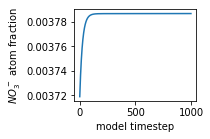

In [29]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(output[['AFNO3-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_3^-$ atom fraction")

plt.tight_layout()
plt.savefig("figures/no3-atomfraction.pdf")

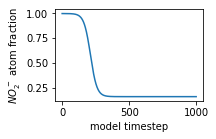

In [30]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(output[['AFNO2-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_2^-$ atom fraction")

plt.tight_layout()
plt.savefig("figures/no2-atomfraction.pdf")

In [31]:
tracers.no2_15[-1]

array([0.11502916])

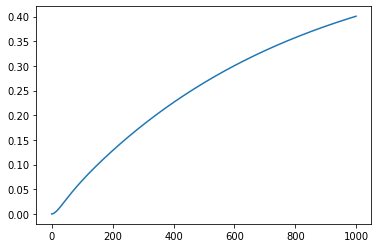

In [32]:
plt.plot(result.x[-1]*(tracers.nh2oh_14+tracers.nh2oh_15)*(tracers.no_14+tracers.no_15))

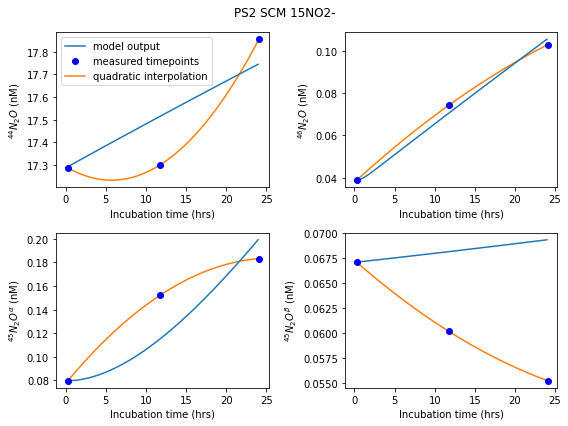

In [33]:
sc.plot_outputs(trainingdata = PS2SCM15NO2, modeloutput=output, 
             filename="Figures/PS2SCM15NO2.pdf")